In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal, ndimage
import time

### Normalized Correlation using Single Block and Multi Block Matching Technique

In [2]:
class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize

    def cross_correlation(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        
        correlations = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            correlation = np.zeros((l, w), dtype = np.float)
            tempL = np.zeros((l, w), dtype = np.float)
            tempR = np.zeros((l, w), dtype = np.float)
            
            correlation[:, :w-i] = np.multiply(imgL[:, i:], imgR[:, :w-i])
            tempL[:, :w-i] = imgL[:, i:]**2
            tempR[:, :w-i] = imgR[:, :w-i]**2
            
            correlation = ndimage.uniform_filter(correlation, self.blockSize)
            tempL = ndimage.uniform_filter(tempL, self.blockSize)
            tempR = ndimage.uniform_filter(tempR, self.blockSize)
            
            correlation = correlation/(np.sqrt(np.multiply(tempL, tempR)))
            correlations.append(correlation.copy())
        
        correlations = np.array(correlations)

        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmax(correlations[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    # Normalized Correlation using Multi Block Matching Technique >> max[min(1x61, 61x1), 11x11, 3x3]
    def cross_correlation_with_MBM(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        
        kernel_61_1 = np.ones((61, 1))
        kernel_1_61 = np.ones((1, 61))
        kernel_11_11 = np.ones((11, 11))
        kernel_3_3 = np.ones((3, 3))
        
        correlations_61_1 = []
        correlations_1_61 = []
        correlations_11_11 = []
        correlations_3_3 = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            #Creating an numpy array with all zeors of same size as input image
            correlation = np.zeros((l, w), dtype = np.float)
            tempL = np.zeros((l, w), dtype = np.float)
            tempR = np.zeros((l, w), dtype = np.float)
            
            #Cross correlation for a given disparity and squaring the images to use it to divide later
            correlation[:, :w-i] = np.multiply(imgL[:, i:], imgR[:, :w-i])
            tempL[:, :w-i] = imgL[:, i:]**2
            tempR[:, :w-i] = imgR[:, :w-i]**2
            
            #Convolving the correlations i.e., adding the values and normalising them using tempL_conv and tempR_conv
            correlation_61_1 = signal.convolve2d(correlation, kernel_61_1, boundary='symm', mode='same')
            tempL_conv = signal.convolve2d(tempL, kernel_61_1, boundary='symm', mode='same')
            tempR_conv = signal.convolve2d(tempR, kernel_61_1, boundary='symm', mode='same')
            correlation_61_1 = correlation_61_1/(np.sqrt(np.multiply(tempL_conv, tempR_conv)))
            
            correlation_1_61 = signal.convolve2d(correlation, kernel_1_61, boundary='symm', mode='same')
            tempL_conv = signal.convolve2d(tempL, kernel_1_61, boundary='symm', mode='same')
            tempR_conv = signal.convolve2d(tempR, kernel_1_61, boundary='symm', mode='same')
            correlation_1_61 = correlation_1_61/(np.sqrt(np.multiply(tempL_conv, tempR_conv)))
            
            correlation_11_11 = signal.convolve2d(correlation, kernel_11_11, boundary='symm', mode='same')
            tempL_conv = signal.convolve2d(tempL, kernel_11_11, boundary='symm', mode='same')
            tempR_conv = signal.convolve2d(tempR, kernel_11_11, boundary='symm', mode='same')
            correlation_11_11 = correlation_11_11/(np.sqrt(np.multiply(tempL_conv, tempR_conv)))
            
            correlation_3_3 = signal.convolve2d(correlation, kernel_3_3, boundary='symm', mode='same')
            tempL_conv = signal.convolve2d(tempL, kernel_3_3, boundary='symm', mode='same')
            tempR_conv = signal.convolve2d(tempR, kernel_3_3, boundary='symm', mode='same')
            correlation_3_3 = correlation_3_3/(np.sqrt(np.multiply(tempL_conv, tempR_conv)))
            
            #Appending correlation for each disparity into a correlations list
            correlations_61_1.append(correlation_61_1.copy())
            correlations_1_61.append(correlation_1_61.copy())
            correlations_11_11.append(correlation_11_11.copy())
            correlations_3_3.append(correlation_3_3.copy())
        
        #Converting correlations list into numpy array
        correlations_61_1 = np.array(correlations_61_1)
        correlations_1_61 = np.array(correlations_1_61)
        correlations_11_11 = np.array(correlations_11_11)
        correlations_3_3 = np.array(correlations_3_3)
        
        out = np.minimum(correlations_61_1, correlations_1_61) 
        out = np.multiply(out, correlations_11_11)
        out = np.multiply(out, correlations_3_3)
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmax(out[:,i,j])
        return disparityMap
    
    # Normalized Correlation using Multiple different kernel sizes
    def cross_correlation_with_input_kernels(self, imgL, imgR, kernels):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        
        correlations = [[] for i in range(len(kernels))]
        
        l, w = imgL.shape
        for i in range(self.numDisparities):
            #Creating an numpy array with all zeors of same size as input image
            correlation = np.zeros((l, w), dtype = np.float)
            tempL = np.zeros((l, w), dtype = np.float)
            tempR = np.zeros((l, w), dtype = np.float)
            
            #Cross correlation for a given disparity and squaring the images to use it to divide later
            correlation[:, :w-i] = np.multiply(imgL[:, i:], imgR[:, :w-i])
            tempL[:, :w-i] = imgL[:, i:]**2
            tempR[:, :w-i] = imgR[:, :w-i]**2
            
            #Convolving the correlations i.e., adding the values and normalising them using tempL_conv and tempR_conv
            correlation_list = [[] for i in range(len(kernels))]
            
            for i in range(len(kernels)):
                correlation_list[i] = signal.convolve2d(correlation, kernels[i], boundary='symm', mode='same')
                tempL_conv = signal.convolve2d(tempL, kernels[i], boundary='symm', mode='same')
                tempR_conv = signal.convolve2d(tempR, kernels[i], boundary='symm', mode='same')
                correlation_list[i] = correlation_list[i]/(np.sqrt(np.multiply(tempL_conv, tempR_conv)))
            
            #Appending correlation for each disparity into a correlations list
            for i in range(len(kernels)):
                correlations[i].append(correlation_list[i].copy())
            
        #Converting correlations list into numpy array
        for i in range(len(kernels)):
            correlations[i] = np.array(correlations[i])
        
        out = correlations[0]
        for i in range(1, len(kernels)):
            out = np.multiply(out, correlations[i])
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmax(out[:,i,j])
        return disparityMap
    
    #Generating Locally Consistent Disparity Map
    def LCDM(self, disparityMap, kernel):
        disparityMap = disparityMap.astype(np.int64)
        output = disparityMap.copy()
        r, c = imgL.shape
        row_mid, col_mid = kernel[0]//2, kernel[1]//2
        
        for i in range(2*row_mid, r-2*row_mid):
            for j in range(2*col_mid, min(c-numdisparities-col_mid, c-2*col_mid)):
                temp = disparityMap[i-row_mid:i+row_mid+1, j-col_mid:j+col_mid+1]
                val = np.bincount(temp.reshape(1, kernel[0]*kernel[1])[0]).argmax()
                output[i, j] = val
        return output

In [24]:
## Input data

# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)
# ground_truth = cv2.imread('tsukuba_r.png', 0)

imgL = cv2.imread('2001/cones/im2.png', 0)
imgR = cv2.imread('2001/cones/im6.png', 0)
ground_truth = cv2.imread('2001/cones/disp6.png', 0)/4

# imgL = cv2.imread('2001/teddy/im2.png', 0)
# imgR = cv2.imread('2001/teddy/im6.png', 0)
# ground_truth = cv2.imread('2001/teddy/disp6.png', 0)/4

# imgL = cv2.imread('2001/sawtooth/im2.ppm', 0)
# imgR = cv2.imread('2001/sawtooth/im6.ppm', 0)
# ground_truth = cv2.imread('2001/sawtooth/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/venus/im2.ppm', 0)
# imgR = cv2.imread('2001/venus/im6.ppm', 0)
# ground_truth = cv2.imread('2001/venus/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/barn1/im2.ppm', 0)
# imgR = cv2.imread('2001/barn1/im6.ppm', 0)
# ground_truth = cv2.imread('2001/barn1/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/bull/im2.ppm', 0)
# imgR = cv2.imread('2001/bull/im6.ppm', 0)
# ground_truth = cv2.imread('2001/bull/disp6.pgm', 0)/8

In [25]:
blocksize = 11
numdisparities = 64
disparity = DisparityMap(numDisparities=numdisparities, blockSize=blocksize)

t1 = time.time()
disparityMap1 = disparity.cross_correlation(imgL, imgR)
t2 = time.time()
disparityMap2 = disparity.LCDM(disparityMap1, (11, 11))

t3 = time.time()
disparityMap3 = disparity.cross_correlation_with_MBM(imgL, imgR)
t4 = time.time()
disparityMap4 = disparity.LCDM(disparityMap3, (11, 11))
print("NCC:", t2-t1)
print("NCC+MBM:", t4-t3)

###############################################################
##Cropping the ground truth
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0

##Calculating error
error1 = abs(ground_truth-disparityMap1)>1
error_per1 = np.round(100*sum(error1.reshape(r*c, 1))[0]/(r*c), 2)

error2 = abs(ground_truth-disparityMap2)>1
error_per2 = np.round(100*sum(error2.reshape(r*c, 1))[0]/(r*c), 2)

error3 = abs(ground_truth-disparityMap3)>1
error_per3 = np.round(100*sum(error3.reshape(r*c, 1))[0]/(r*c), 2)

error4 = abs(ground_truth-disparityMap4)>1
error_per4 = np.round(100*sum(error4.reshape(r*c, 1))[0]/(r*c), 2)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


NCC: 1.0133342742919922
NCC+MBM: 33.04457426071167


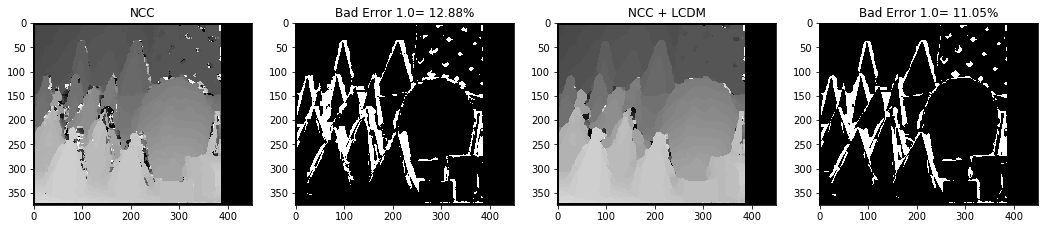

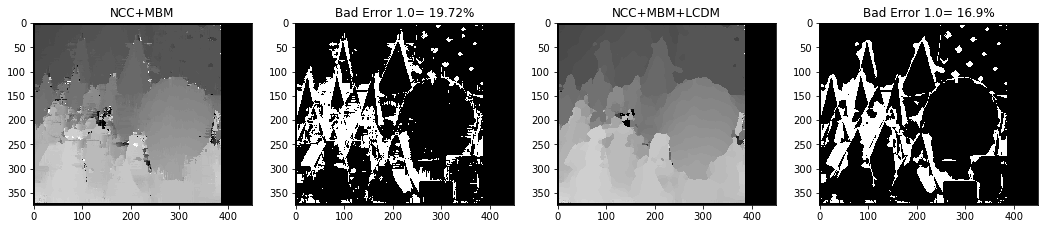

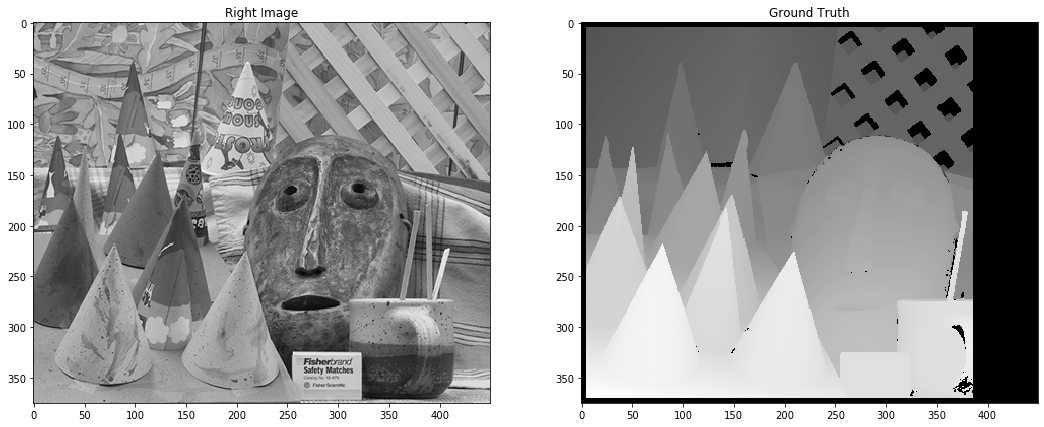

In [26]:
###############################################################
##Cropping the ground truth
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0

##Calculating error
error1 = (abs(ground_truth-disparityMap1)>1) & (ground_truth!=0)
error_per1 = np.round(100*sum(error1.reshape(r*c, 1))[0]/(r*c), 2)

error2 = (abs(ground_truth-disparityMap2)>1) & (ground_truth!=0)
error_per2 = np.round(100*sum(error2.reshape(r*c, 1))[0]/(r*c), 2)

error3 = (abs(ground_truth-disparityMap3)>1) & (ground_truth!=0)
error_per3 = np.round(100*sum(error3.reshape(r*c, 1))[0]/(r*c), 2)

error4 = (abs(ground_truth-disparityMap4)>1) & (ground_truth!=0)
error_per4 = np.round(100*sum(error4.reshape(r*c, 1))[0]/(r*c), 2)

##################################################################
plt.figure(figsize=(18, 72))
plt.subplot(141)
plt.imshow(disparityMap1, 'gray')
plt.title('NCC')

plt.subplot(142)
plt.imshow(error1, 'gray')
plt.title('Bad Error 1.0= '+str(error_per1)+'%')

plt.subplot(143)
plt.imshow(disparityMap2, 'gray')
plt.title('NCC + LCDM')

plt.subplot(144)
plt.imshow(error2, 'gray')
plt.title('Bad Error 1.0= '+str(error_per2)+'%')
plt.show()

##################################
plt.figure(figsize=(18, 72))
plt.subplot(141)
plt.imshow(disparityMap3, 'gray')
plt.title('NCC+MBM')

plt.subplot(142)
plt.imshow(error3, 'gray')
plt.title('Bad Error 1.0= '+str(error_per3)+'%')

plt.subplot(143)
plt.imshow(disparityMap4, 'gray')
plt.title('NCC+MBM+LCDM')

plt.subplot(144)
plt.imshow(error4, 'gray')
plt.title('Bad Error 1.0= '+str(error_per4)+'%')
plt.show()

###################################################################
plt.figure(figsize=(18, 27))
plt.subplot(121)
plt.imshow(imgR, 'gray')
plt.title('Right Image')

plt.subplot(122)
plt.imshow(ground_truth, 'gray')
plt.title('Ground Truth')
plt.show()